In [23]:
subj = "Subj1"
exp = "exp_sep2"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = (exp != "reproduction")
scale = False

### Imports

In [24]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [25]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj1/src/data_rr_filt-raw.fif...
    Range : 3500 ... 471000 =      7.000 ...   942.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj1\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated
Features:  (1046, 64)


In [26]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    if exp != "reproduction": features = features[:-2]

### SDA

In [27]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1046 samples with 64 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [28]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in  tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0   39  282  492  560  682  784  857  976 1046]


100%|██████████| 2016/2016 [00:06<00:00, 326.35it/s]


In [29]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [30]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(features, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/stats.svg")
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")

#### Internal

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0           60        40        20         3    Mode   
1            0        40        10         4    Mode   
2            0        40        10         5    Mode   
3            0        45        20         6    Mode   
4           60        40        15         7    Mode   
5           60        35        15         8  Median   
6            0        40        20         9  Median   
7            0        40        20        10  Median   
8            0        50        15        11    Mode   
9           60        50        20        12    Mean   
10          40        50        20        13  Median   
11          60        35        20        14    Mode   
12          60        35        20        15    Mode   
13          20        50        20        16    Mode   

                                             St_edges  Ward_dist  Cen_dist  \
0                                 [0, 486, 682, 1046]  182615.11     36.25   
1                            [0, 210, 682, 842, 1046]  125412.70     31.93   
2                       [0, 210, 552, 682, 842, 1046]  165819.01     41.95   
3                  [0, 210, 552, 682, 842, 976, 1046]  161541.44     44.92   
4             [0, 124, 210, 552, 682, 842, 976, 1046]  131157.37     42.68   
5        [0, 124, 210, 299, 552, 682, 842, 976, 1046]  106222.83     38.29   
6    [0, 81, 210, 341, 547, 681, 784, 842, 977, 1046]   82953.13     37.31   
7   [0, 81, 210, 341, 547, 681, 784, 842, 976, 103...   73792.11     36.26   
8   [0, 45, 186, 210, 341, 486, 552, 682, 799, 842...   56123.40     34.57   
9   [0, 91, 127, 211, 275, 342, 482, 551, 681, 777...   51017.40     32.21   
10  [0, 45, 92, 124, 210, 265, 341, 486, 552, 682,...   50635.44     33.34   
11  [0, 81, 126, 186, 210, 275, 341, 449, 486, 552...   43057.76     30.62   
12  [0, 81, 126, 186, 210, 275, 341, 372, 449, 486...   40516.97     30.43   
13  [0, 45, 92, 123, 210, 265, 341, 486, 552, 647,...   31266.80     31.19   

        Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI  \
0   2.63e-02    37.18      5.30      0.06        47.02          3.46  0.65   
1   1.64e-02    29.02      6.75      0.05        31.58          3.89  0.66   
2   1.87e-02    35.90      5.18      0.09        44.26          2.98  0.75   
3   2.13e-02    34.10      5.64      0.10        42.53          2.73  0.79   
4   5.01e-03    31.17      5.35      0.09        34.86          2.83  0.77   
5   1.92e-04    27.96      5.51      0.08        28.24          3.36  0.80   
6  -6.91e-03    25.79      5.35      0.07        22.24          3.42  0.81   
7  -6.70e-03    23.24      5.32      0.07        19.81          3.55  0.81   
8  -1.78e-02    21.91      5.05      0.06        15.12          3.58  0.83   
9  -1.35e-02    20.41      5.27      0.06        13.66          3.90  0.82   
10 -3.38e-02    19.87      4.94      0.06        14.02          3.58  0.83   
11 -1.82e-02    17.92      5.53      0.06        11.58          4.19  0.80   
12 -1.81e-02    16.88      5.60      0.06        10.91          4.19  0.79   
13 -3.48e-02    16.83      5.30      0.06         8.96          3.90  0.80   

     ARI   FMI  
0   0.43  0.61  
1   0.42  0.57  
2   0.58  0.67  
3   0.62  0.69  
4   0.57  0.65  
5   0.64  0.69  
6   0.64  0.69  
7   0.63  0.68  
8   0.69  0.74  
9   0.64  0.70  
10  0.66  0.72  
11  0.60  0.66  
12  0.57  0.64  
13  0.59  0.67

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0           0        40        20         9  Median   

                                           St_edges  Ward_dist  Cen_dist  \
0  [0, 81, 210, 341, 547, 681, 784, 842, 977, 1046]   82953.13     37.31   

       Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI  \
0 -6.91e-03    25.79      5.35      0.07        22.24          3.42  0.81   

    ARI   FMI  
0  0.64  0.69

array([   0,   81,  210,  341,  547,  681,  784,  842,  977, 1046])

Silh  Cal-Har  Dav-Bold       Ward  Centr
0  0.05    15.88      3.33   45236.62  30.15
1  0.05    13.09      4.30   43091.79  25.75
2  0.02     9.01      5.74   32153.53  20.04
3  0.09    39.65      2.79  148474.67  42.76
4  0.14    45.21      2.20  165552.54  53.32
5  0.06    10.56      3.62   38668.43  32.28
6  0.10    24.89      2.42  104212.13  50.68
7  0.08    19.61      2.93   86235.36  43.46

0              1               2  \
Start-end time, sec  (9.9, 80.3)  (81.1, 198.7)  (199.5, 317.1)   
Time length, sec            70.4          117.6           117.6   
Number of epochs              81            129             131   

                                  3               4               5  \
Start-end time, sec  (319.5, 501.1)  (501.9, 619.5)  (620.3, 707.5)   
Time length, sec              181.6           117.6            87.2   
Number of epochs                206             134             103   

                                  6               7               8  
Start-end time, sec  (708.3, 758.7)  (759.5, 877.9)  (878.7, 938.7)  
Time length, sec               50.4           118.4            60.0  
Number of epochs                 58             135              69

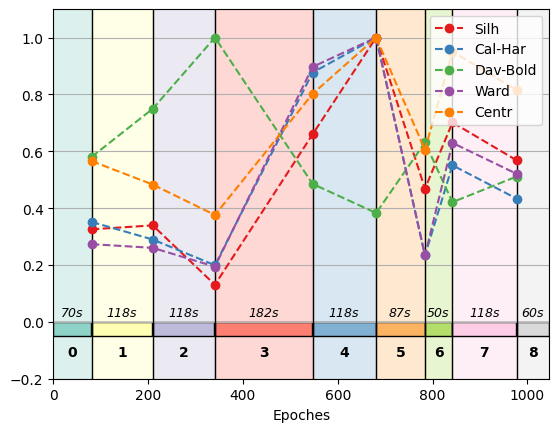

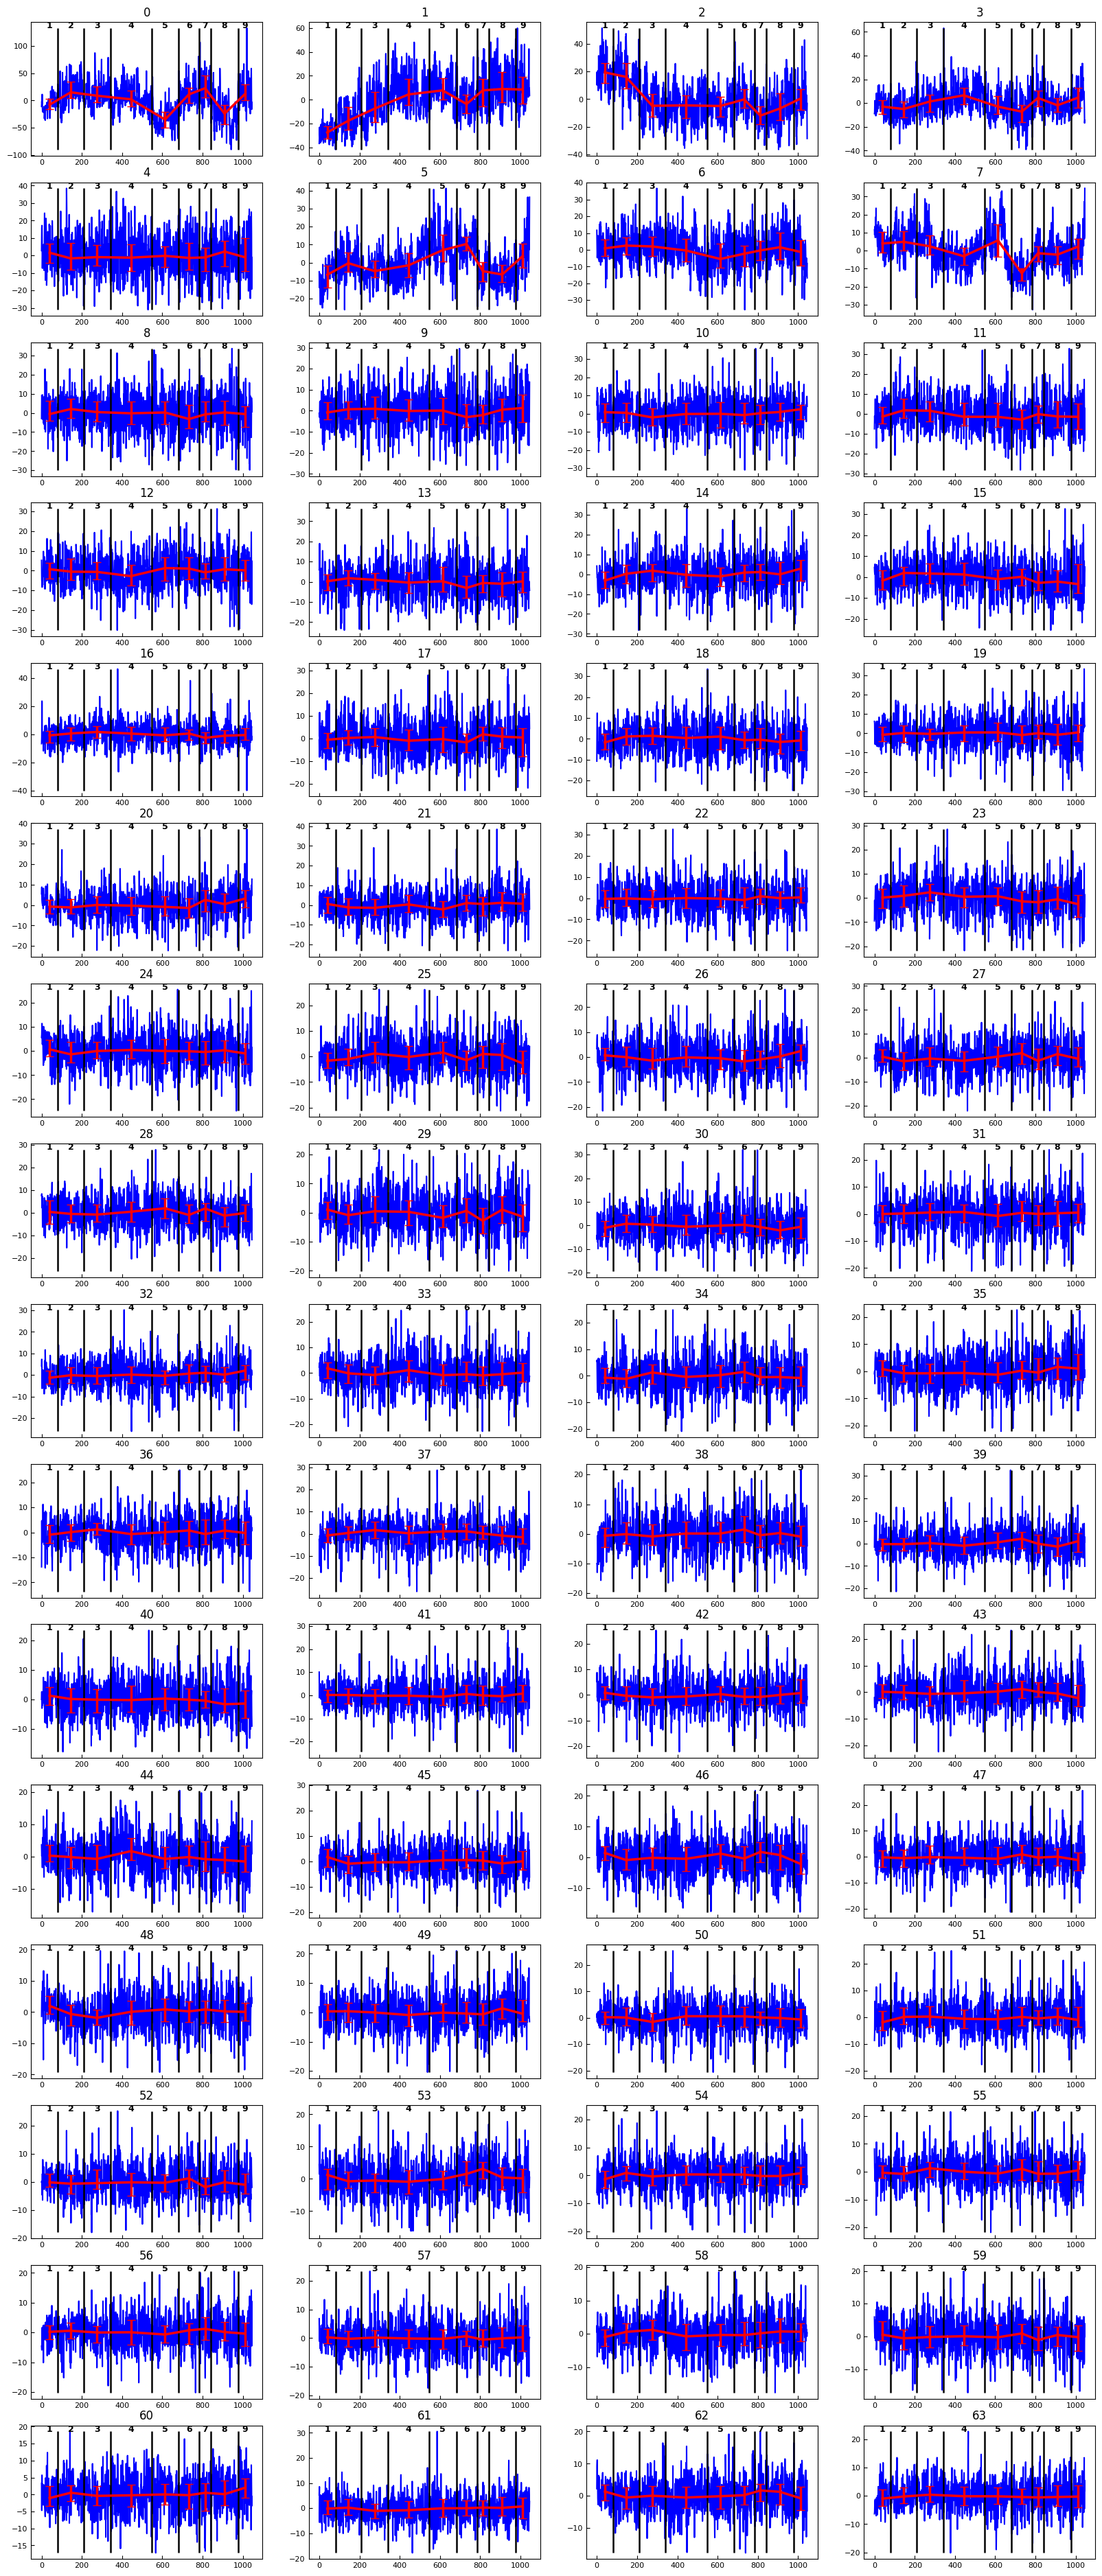

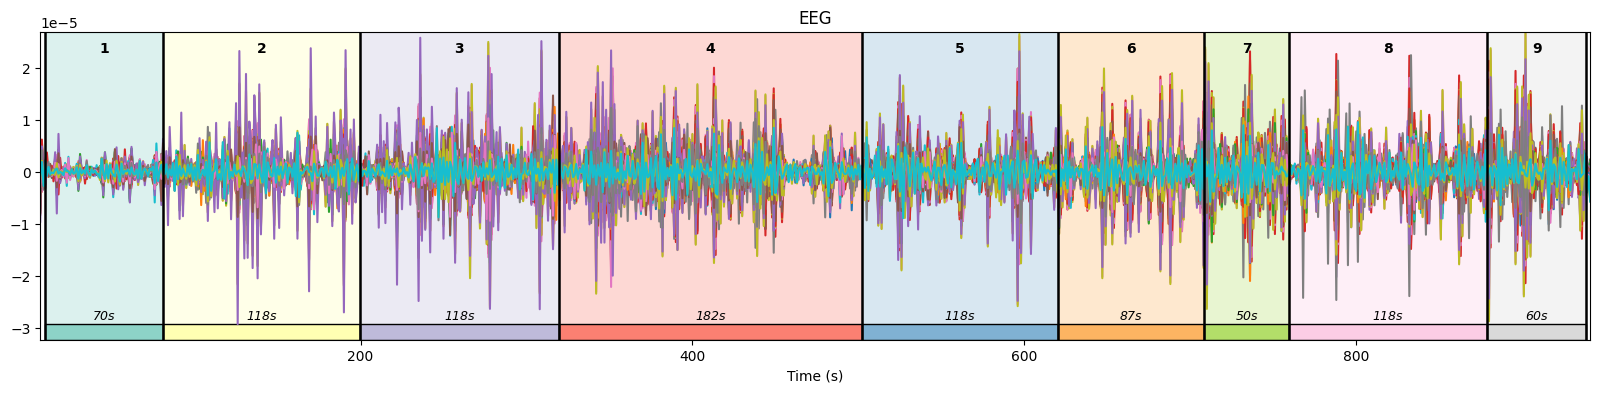

In [31]:
analyze(result, 'Avg-Silh', "internal")
# [   0   39  282  492  560  682  784  857  976 1046]
# array([   0,   46,  210,  340,  554,  682,  784,  846,  975, 1046])

![Alternative Text][1707850881559]

[1707850881559]: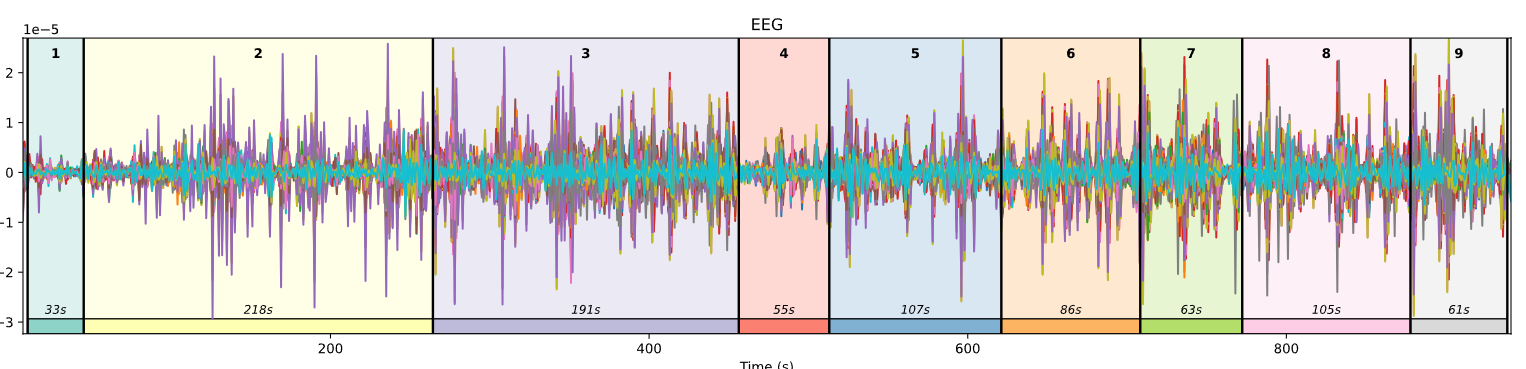

#### External

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0           60        40        20         3    Mode   
1           60        35        20         4  Median   
2           60        45        20         5  Median   
3            0        35        20         6    Mode   
4           20        35        20         7    Mean   
5            0        35        10         8  Median   
6            0        35        10         9  Median   
7           60        35        15        10    Mode   
8           40        35        15        11  Median   
9           20        35        15        12  Median   
10           0        40        15        13  Median   
11           0        40        15        14  Median   
12           0        40        15        15  Median   
13           0        45        15        16  Median   

                                             St_edges  Ward_dist  Cen_dist  \
0                                 [0, 486, 682, 1046]  182615.11     36.25   
1                            [0, 210, 555, 842, 1046]   78841.01     22.83   
2                       [0, 210, 552, 682, 855, 1046]  164278.00     41.45   
3                   [0, 46, 486, 682, 842, 976, 1046]  149870.55     44.06   
4              [0, 86, 260, 528, 674, 831, 978, 1046]  110392.12     37.46   
5         [0, 81, 210, 282, 547, 682, 842, 976, 1046]  107562.94     38.47   
6    [0, 81, 210, 282, 486, 552, 682, 842, 976, 1046]   81909.48     35.80   
7   [0, 81, 210, 275, 486, 552, 682, 776, 842, 976...   65075.18     35.52   
8   [0, 46, 126, 210, 299, 486, 552, 682, 783, 842...   57781.65     33.56   
9   [0, 46, 126, 210, 275, 341, 486, 552, 682, 783...   53022.63     32.66   
10  [0, 46, 124, 210, 275, 341, 486, 552, 682, 784...   49604.89     34.01   
11  [0, 46, 124, 210, 275, 341, 486, 552, 682, 784...   42564.64     32.67   
12  [0, 46, 124, 186, 217, 275, 341, 486, 552, 682...   37942.26     30.99   
13  [0, 46, 81, 124, 200, 229, 275, 341, 486, 552,...   35868.41     30.87   

        Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI  \
0   2.63e-02    37.18      5.30      0.06        47.02          3.46  0.65   
1   1.51e-02    27.09      6.77      0.04        21.38          6.12  0.68   
2   1.91e-02    35.72      5.35      0.09        43.75          3.02  0.76   
3  -6.97e-03    29.39      5.64      0.08        38.89          2.69  0.81   
4  -4.84e-03    27.55      5.78      0.07        28.79          3.24  0.79   
5  -1.34e-02    27.80      5.55      0.07        28.45          3.24  0.83   
6  -1.51e-02    25.76      5.28      0.06        21.78          3.42  0.86   
7  -1.43e-02    24.12      5.21      0.06        17.56          3.45  0.87   
8  -1.47e-02    22.34      5.23      0.06        15.63          3.68  0.86   
9  -1.79e-02    20.93      5.15      0.06        14.42          3.78  0.85   
10 -2.58e-02    19.47      4.90      0.05        13.49          3.62  0.85   
11 -2.58e-02    18.31      5.07      0.05        11.70          3.82  0.84   
12 -2.72e-02    17.02      5.32      0.05        10.35          4.11  0.83   
13 -4.42e-02    16.11      5.21      0.04         9.87          4.01  0.82   

     ARI   FMI  
0   0.43  0.61  
1   0.50  0.62  
2   0.59  0.67  
3   0.61  0.71  
4   0.69  0.74  
5   0.70  0.74  
6   0.76  0.79  
7   0.77  0.81  
8   0.74  0.78  
9   0.69  0.74  
10  0.69  0.74  
11  0.67  0.73  
12  0.65  0.71  
13  0.63  0.70

St_len_min  K_nb_max  N_cl_max  N_stages  Cl_cen  \
0           0        35        10         9  Median   

                                           St_edges  Ward_dist  Cen_dist  \
0  [0, 81, 210, 282, 486, 552, 682, 842, 976, 1046]   81909.48      35.8   

   Silh  Cal-Har  Dav-Bold  Avg-Silh  Avg-Cal-Har  Avg-Dav-Bold   AMI   ARI  \
0 -0.02    25.76      5.28      0.06        21.78          3.42  0.86  0.76   

    FMI  
0  0.79

array([   0,   81,  210,  282,  486,  552,  682,  842,  976, 1046])

Silh  Cal-Har  Dav-Bold       Ward  Centr
0  0.05    15.88      3.33   45236.62  30.15
1  0.04     9.93      4.12   31517.42  26.12
2  0.01     9.20      4.50   32799.38  24.83
3  0.02    10.07      4.22   36584.19  27.09
4  0.05    13.74      3.42   48457.12  33.27
5  0.14    58.00      2.16  220432.03  55.44
6  0.10    37.25      2.70  151853.24  45.63
7  0.08    20.15      2.91   88395.82  43.85

0              1               2  \
Start-end time, sec  (9.9, 80.3)  (81.1, 198.7)  (199.5, 263.5)   
Time length, sec            70.4          117.6            64.0   
Number of epochs              81            129              72   

                                  3               4               5  \
Start-end time, sec  (264.3, 449.9)  (450.7, 505.1)  (505.9, 620.3)   
Time length, sec              185.6            54.4           114.4   
Number of epochs                204              66             130   

                                  6               7               8  
Start-end time, sec  (621.1, 758.7)  (759.5, 877.1)  (877.9, 938.7)  
Time length, sec              137.6           117.6            60.8  
Number of epochs                160             134              70

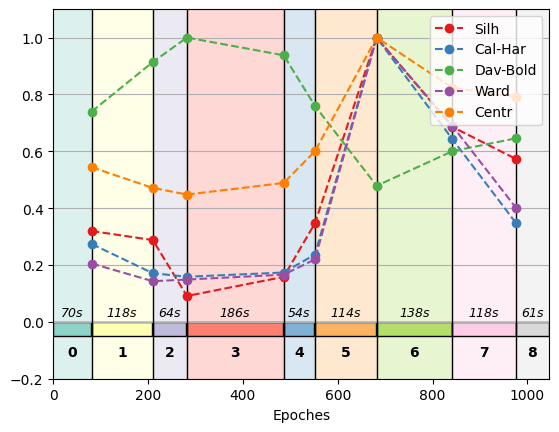

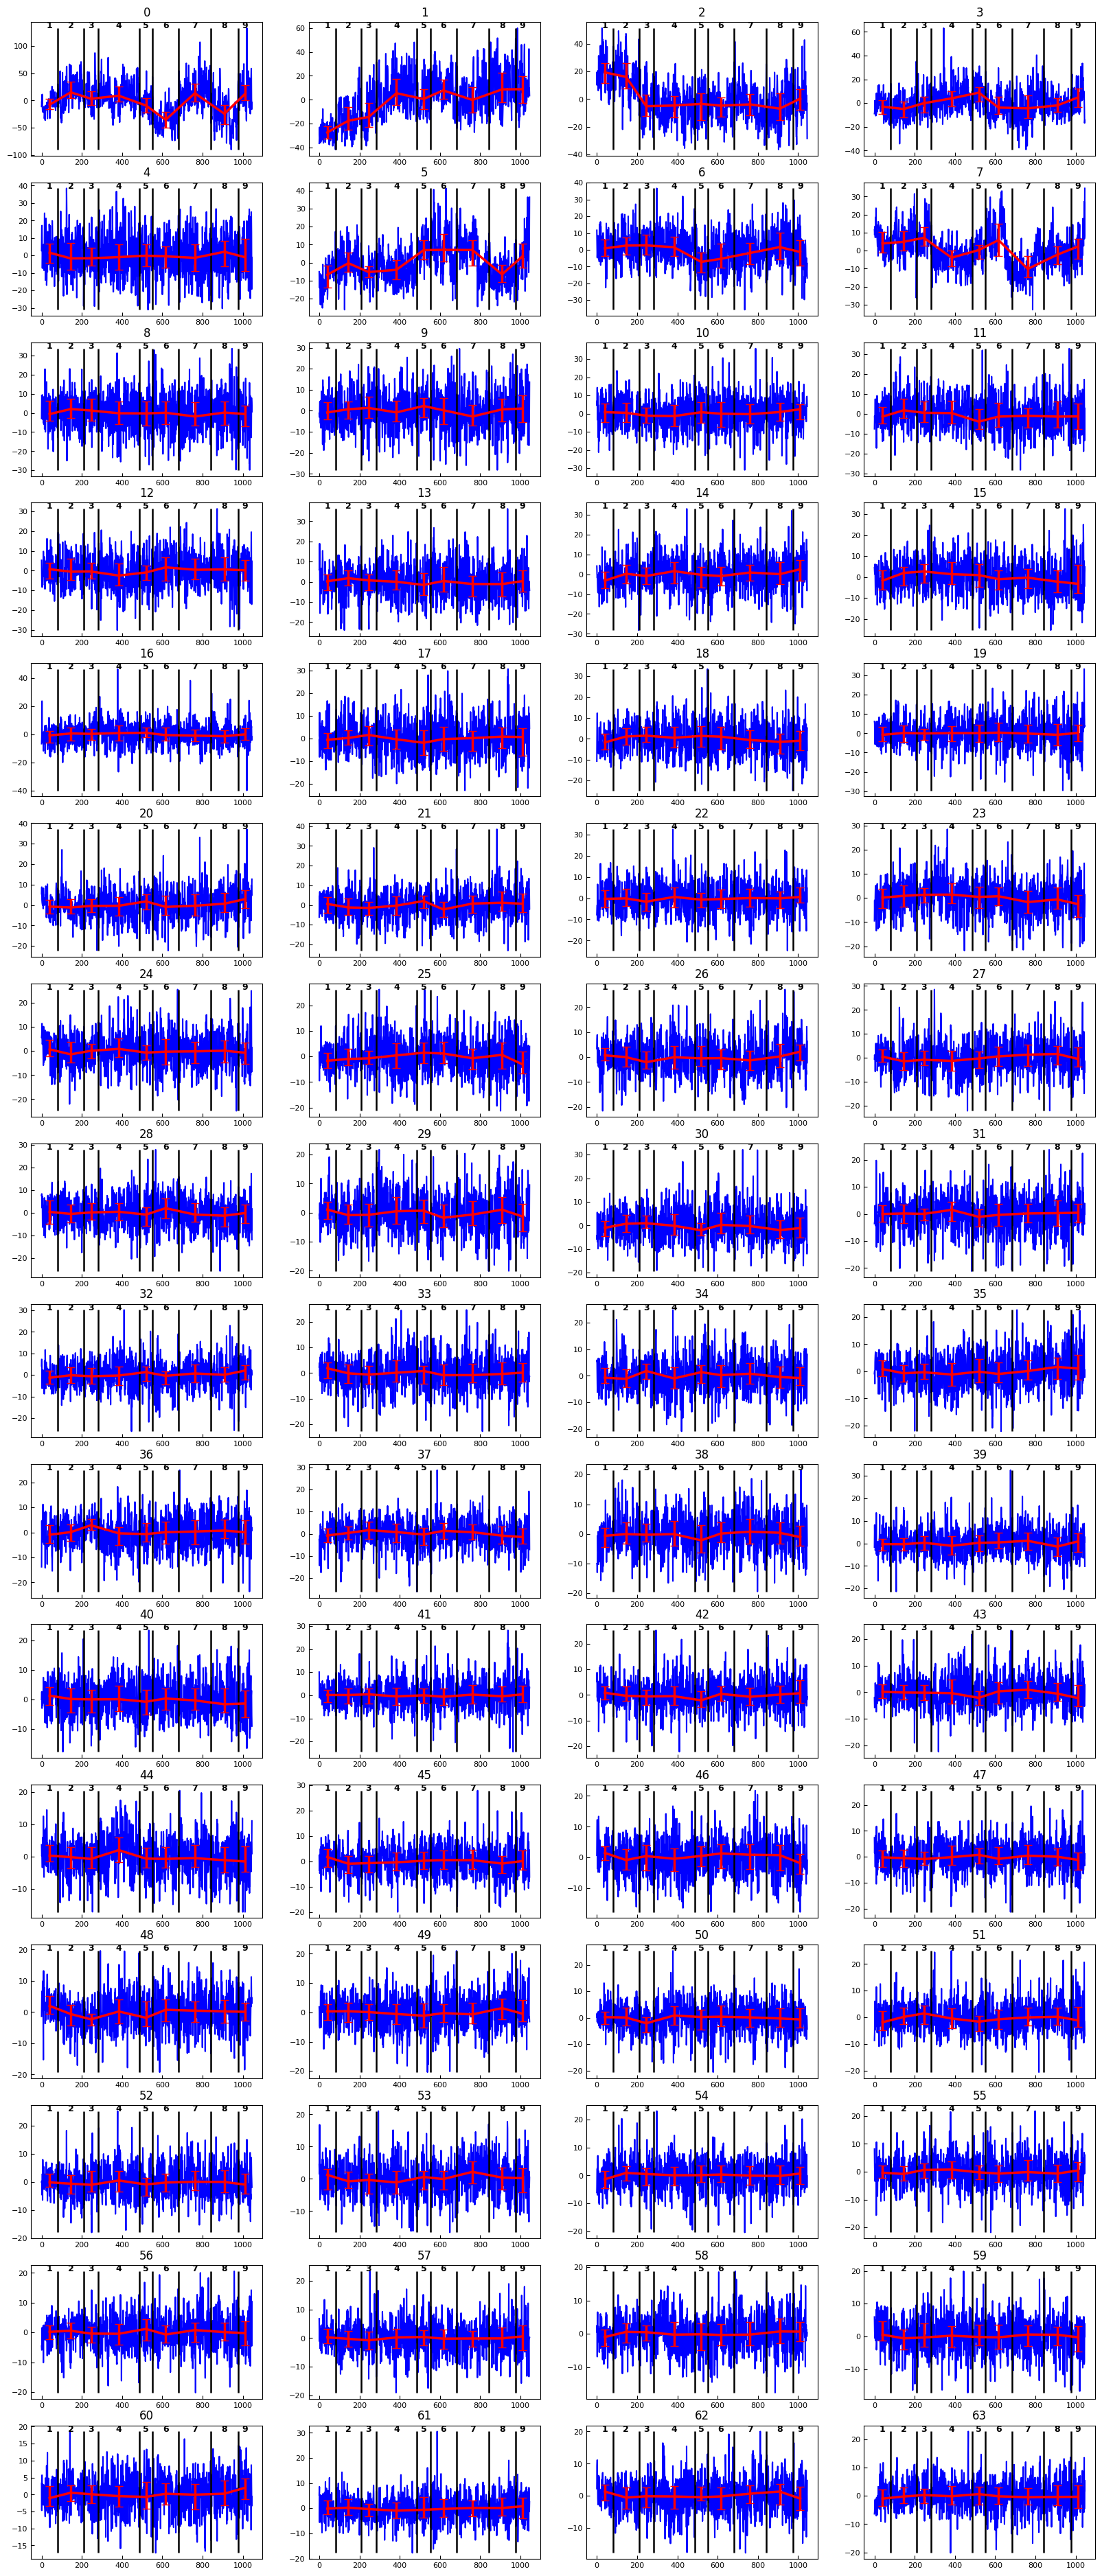

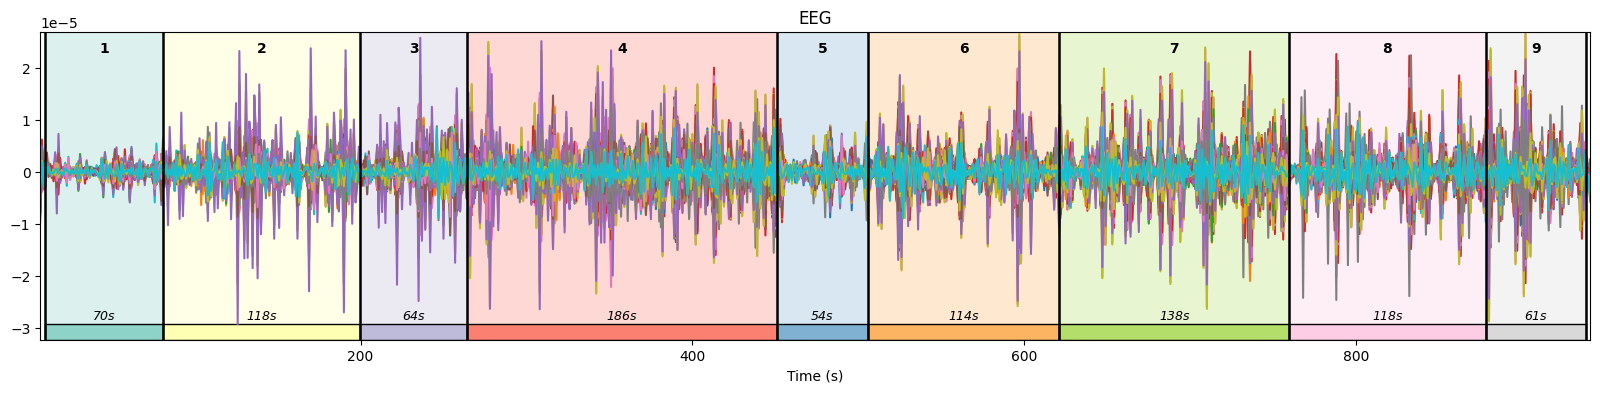

In [32]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")
# [   0   39  282  492  560  682  784  857  976 1046]

![Alternative Text][1707850881559]

[1707850881559]: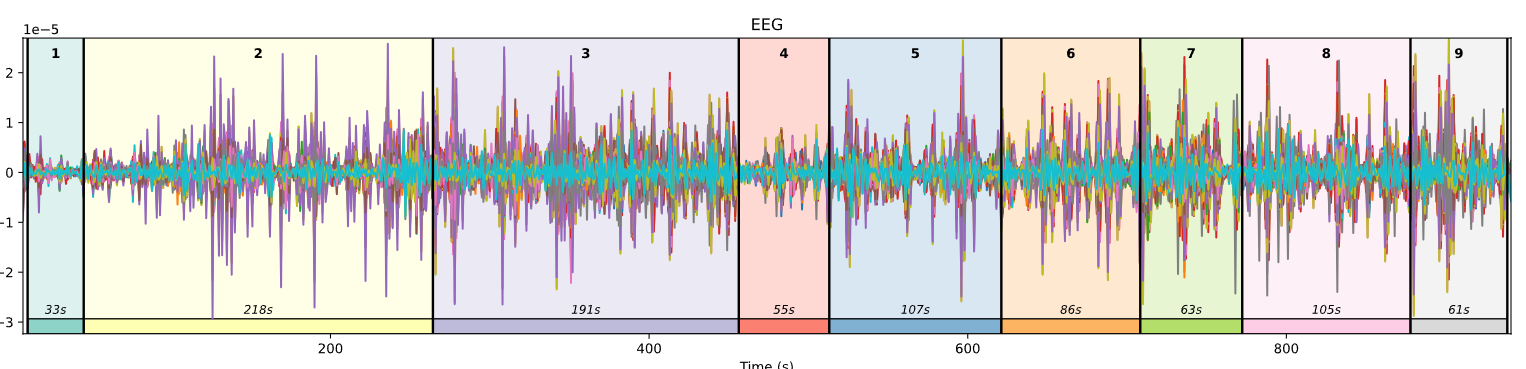